In [1]:
import tensorflow as tf
from ray.rllib.offline.json_reader import JsonReader
import numpy as np
import numpy_indexed as npi
import pandas as pd
from IPython.display import display
import graphviz
import numpy as np
import ipywidgets as widgets
import os
from pathlib import Path

/usr/local/lib/python3.8/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [2]:
def convert_ts_np_to_df(df,np_true_state,prefix):
#     column_dict = {}
    newdf = pd.DataFrame()
    for node in range(13):
        newdf[f"{node}_ts_{prefix}_known_status"] = (np_true_state[:,node*6+0] + (np_true_state[:,node*6+1]*2) + (np_true_state[:,node*6+2]*3)) -1
        newdf[f"{node}_ts_{prefix}_access_status"] = (np_true_state[:,node*6+3] + (np_true_state[:,node*6+4]*2) + (np_true_state[:,node*6+5]*3)) -1 
        
        assert((newdf[f"{node}_ts_{prefix}_known_status"]>=0).all())
        assert((newdf[f"{node}_ts_{prefix}_known_status"]<3).all())
        assert((newdf[f"{node}_ts_{prefix}_access_status"]>=0).all())
        assert((newdf[f"{node}_ts_{prefix}_access_status"]<4).all())
        
        # SHIFT THEM FORWARDS TO GET prev obs => pre actions => true states => obs => action (and reward)
        temp_df = newdf[f"{node}_ts_{prefix}_known_status"].copy(deep=True)
        temp_df = temp_df.shift(periods=1)
        temp_df.iloc[::100] = 0.0
        newdf[f"{node}_ts_{prefix}_known_status"] = temp_df.copy(deep=True)
        
        temp_df = newdf[f"{node}_ts_{prefix}_access_status"].copy(deep=True)
        temp_df = temp_df.shift(periods=1)
        temp_df.iloc[::100] = 0.0
        newdf[f"{node}_ts_{prefix}_access_status"] = temp_df.copy(deep=True)
        
        newdf[f"{node}_ts_{prefix}_known_status"] = newdf[f"{node}_ts_{prefix}_known_status"].astype("category")
        newdf[f"{node}_ts_{prefix}_access_status"] = newdf[f"{node}_ts_{prefix}_access_status"].astype("category")
        
        assert (newdf[f"{node}_ts_{prefix}_known_status"].iloc[::100] == 0.0).all()
        assert (newdf[f"{node}_ts_{prefix}_access_status"].iloc[::100] == 0.0).all()
        #     df = pd.DataFrame(column_dict)
    return pd.concat([df, newdf],axis=1)


def convert_obs_np_to_df(df,np_blue_obs):
#     column_dict = {}
    newdf = pd.DataFrame()
    for node in range(13):
        newdf[f"{node}_obs_blue_activity"] = (np_blue_obs[:,node*7+0] + (np_blue_obs[:,node*7+1]*2) + (np_blue_obs[:,node*7+2]*3)) -1
        newdf[f"{node}_obs_blue_compromised"] = (np_blue_obs[:,node*7+3] + (np_blue_obs[:,node*7+4]*2) + (np_blue_obs[:,node*7+5]*3) + (np_blue_obs[:,node*7+6]*4)) -1  
        
        
#         assert(df[f"{node}_obs_blue_activity"])
#         print(np_blue_obs[:,node*6+0:node*6+3])
        assert((newdf[f"{node}_obs_blue_activity"]>=0).all())
        assert((newdf[f"{node}_obs_blue_activity"]<3).all())
        assert((newdf[f"{node}_obs_blue_compromised"]>=0).all())
        assert((newdf[f"{node}_obs_blue_compromised"]<4).all())
        
        newdf[f"{node}_obs_blue_activity"] = newdf[f"{node}_obs_blue_activity"].astype("category")
        newdf[f"{node}_obs_blue_compromised"] = newdf[f"{node}_obs_blue_compromised"].astype("category")
        
        # To get prev activity:
        # copy activity field for this node and shift it replacing every 100th as initialised value
        temp_df = newdf[f"{node}_obs_blue_activity"].copy(deep=True)
        temp_df = temp_df.shift(periods=1)
        temp_df.iloc[::100] = 2.0
        newdf[f"{node}_prev_obs_blue_activity"] = temp_df.copy(deep=True)
        
        # To get prev compromised:
        # copy compromised field for this node and shift it replacing every 100th as initialised value
        temp_df = newdf[f"{node}_obs_blue_compromised"].copy(deep=True)
        temp_df = temp_df.shift(periods=1)
        temp_df.iloc[::100] = 3.0
        newdf[f"{node}_prev_obs_blue_compromised"] = temp_df.copy(deep=True)
        
        assert (newdf[f"{node}_prev_obs_blue_activity"].iloc[::100] == 2.0).all()
        assert (newdf[f"{node}_prev_obs_blue_compromised"].iloc[::100] == 3.0).all()

    return pd.concat([df, newdf],axis=1)

def convert_acts_rwds_prevacts_nps_to_df(df, np_actions, np_rewards, np_prevact):
    newdf = pd.DataFrame()
    newdf["action_blue"] = np_actions
    newdf["action_blue"] = newdf["action_blue"].astype("category")
    
    newdf["reward"] = np_rewards
#     newdf["reward"] = newdf["reward"].astype("category")
    
    newdf["prev_action_blue"] = np_prevact
    newdf["prev_action_blue"] = newdf["prev_action_blue"].astype("category")
    
    return pd.concat([df, newdf],axis=1)


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def create_empty_df():
    columns = []
    for node in range(13):
        columns.append(f"{node}_ts_pre_known_status")
        columns.append(f"{node}_ts_pre_access_status")

        columns.append(f"{node}_ts_blue_known_status")
        columns.append(f"{node}_ts_blue_access_status")

        columns.append(f"{node}_ts_red_known_status")
        columns.append(f"{node}_ts_red_access_status")

        columns.append(f"{node}_obs_blue_activity")
        columns.append(f"{node}_obs_blue_compromised")
        
        columns.append(f"{node}_prev_obs_blue_activity")
        columns.append(f"{node}_prev_obs_blue_compromised")

    columns.append(f"prev_action_blue")
    columns.append(f"action_blue")
    columns.append(f"reward")


    full_df = pd.DataFrame(columns=columns)
    return full_df

In [4]:
def convert_rllib_data_to_pandas_parquet_chunks(path, chunk_size, data_size):
    json_path = f"logs/APPO/{path}"
    parquet_path = f"parquet_data/{path}"
    new_data_path = f"{parquet_path}/chunks_{chunk_size}"
    os.makedirs(new_data_path, exist_ok=True)

    input_reader = JsonReader(json_path)

    # dfs = []
    empty_df = create_empty_df()
    full_df = empty_df.copy(deep=True)
    chunk_idx = 0

    for e in range(data_size):#4884
        data = input_reader.next()
                
        df = pd.DataFrame()

        data = input_reader.next()
        assert(data["obs"].shape[0] == data["pre_action_true_states"].shape[0])

        df = convert_ts_np_to_df(df, data["pre_action_true_states"],"pre")
        df = convert_ts_np_to_df(df, data["blue_action_true_states"],"blue")
        df = convert_ts_np_to_df(df, data["red_action_true_states"],"red")

        df = convert_obs_np_to_df(df, data["obs"])
        
        
        
        df = convert_acts_rwds_prevacts_nps_to_df(df, data["actions"], data["rewards"], data["prev_actions"])

        full_df = pd.concat([full_df, df],axis=0)
        # print(len(full_df))
        if len(full_df) >= chunk_size or e+1 == data_size:
            new_chunk_path = f"{new_data_path}/chunk_{chunk_idx}.parquet"
            # display.clear_output(wait=False)
            print(f"saving chunk {chunk_idx} of size {len(full_df)} to {new_chunk_path} ...", flush=True)
            full_df.to_parquet(new_chunk_path)
            full_df = empty_df.copy(deep=True)
            chunk_idx += 1
    return full_df
    

In [5]:
# data_path = "TrueStates_1221_4000_B_Line"
# chunk_size = 100_000
# read_count = 4884

data_path = "TrueStates_200_4000_Meander_badblue"
chunk_size = 100_000
read_count = 800

df = convert_rllib_data_to_pandas_parquet_chunks(data_path, chunk_size, read_count)#4884

2023-02-08 15:23:22,212	WARNING json_reader.py:239 -- Treating input directory as glob patterns: ['/tf/Cage/Notebooks/logs/APPO/TrueStates_200_4000_Meander_badblue/*.json', '/tf/Cage/Notebooks/logs/APPO/TrueStates_200_4000_Meander_badblue/*.zip']


saving chunk 0 of size 100000 to parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_0.parquet ...
saving chunk 1 of size 100000 to parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_1.parquet ...
saving chunk 2 of size 100000 to parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_2.parquet ...
saving chunk 3 of size 100000 to parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_3.parquet ...
saving chunk 4 of size 100000 to parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_4.parquet ...
saving chunk 5 of size 100000 to parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_5.parquet ...
saving chunk 6 of size 100000 to parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_6.parquet ...
saving chunk 7 of size 100000 to parquet_data/TrueStates_200_4000_Meander_badblue/chunks_100000/chunk_7.parquet ...


In [6]:
# TO TEST THAT IT LOADS AGAIN OKAY

chunks_data_path = "parquet_data/TrueStates_1221_4000_B_Line/chunks_10000"

full_df = create_empty_df()

pathlist = Path(chunks_data_path).glob('**/*.parquet')
for path in pathlist:
    # because path is object not string
    print(f"loading chunk: {path}")
    chunk_df = pd.read_parquet(path)
    full_df = pd.concat([full_df, chunk_df])
    
df = full_df

loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_24.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_27.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_34.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_8.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_38.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_19.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_26.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_17.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_36.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_5.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/chunks_10000/chunk_37.parquet
loading chunk: parquet_data/TrueStates_1221_4000_B_Line/

In [7]:
print(df.head(10))

  0_ts_pre_known_status 0_ts_pre_access_status 0_ts_blue_known_status  \
0                     0                      0                      0   
1                     0                      0                      0   
2                     0                      0                      0   
3                     0                      0                      0   
4                     0                      0                      0   
5                     0                      0                      0   
6                     0                      0                      0   
7                     0                      0                      0   
8                     0                      0                      0   
9                     0                      0                      0   

  0_ts_blue_access_status 0_ts_red_known_status 0_ts_red_access_status  \
0                       0                     0                      0   
1                       0                     0 

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
len(df)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


390000

In [18]:
from true_state_viewer import BlueObsTreeGraphViz
import ipywidgets as widgets
from IPython.display import display as idisplay

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
def get_columns_for_training():
    true_states = ["pre","blue","red", "_"]
    ts_columns = {}
    for true_state in true_states:
        ts_columns[true_state] = []
        for node in range(13):
            ts_columns[true_state].append(f"{node}_ts_{true_state}_known_status")
            ts_columns[true_state].append(f"{node}_ts_{true_state}_access_status")
    ts_columns["obs"] = []
    for node in range(13):
        ts_columns["obs"].append(f"{node}_obs_blue_activity")
        ts_columns["obs"].append(f"{node}_obs_blue_compromised")
    ts_columns["pre_obs"] = []
    for node in range(13):
        ts_columns["pre_obs"].append(f"{node}_pre_obs_blue_activity")
        ts_columns["pre_obs"].append(f"{node}_pre_obs_blue_compromised")
    return ts_columns

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


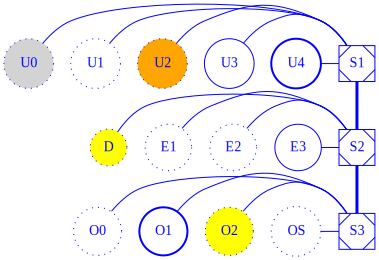

In [26]:
arr = np.array([[2,2],[2,3],[2,3],[1,3],[2,3],[0,3],[2,2],[2,3],[2,1],[2,3],[2,0],[1,3],[0,3]])
tree = BlueObsTreeGraphViz(arr)
tree.display()

In [30]:
cols_dict = get_columns_for_training()
blue_obs_df = df[cols_dict["obs"]]

ims = []
for i in range(38800,38900,1):
    tree = BlueObsTreeGraphViz(np.reshape(blue_obs_df.iloc[i,:].values, (-1,2)))
    ims.append(widgets.HBox([widgets.Image(value = tree.g.pipe(), format='png', width=150),widgets.Image(value = tree.g.pipe(), format='png', width=150)]))

sidebyside_images = widgets.VBox(ims) 
idisplay(sidebyside_images)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
